## Intro

1. Jupyter is great. It combines the ability to iterate and experiment in the Python interactive terminal with the ability to save, re-execute, and share a Python script file.
2. Matplotlib and Pandas seemed intimidating, but it turns out to be easy to just use some of the basic features. 
3. DataFrames are very powerful.
4. It's nice to be able to create data visualizations quickly with just a few lines of code.

I'll show you how I quickly set up a data visualization of Covid-19 cases history in Vermont using some of the basic features of Pandas and Matplotlib.  

In [1]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import json
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

pd_start = datetime.datetime(2020, 3, 11).date() # who declares start of pandemic
pd_days = (datetime.datetime.now().date() - pd_start).days

After imports, I set up utility functions that will be used later.

The source data stores date timestamps in a Unix Epoch timestamp in milliseconds. The `get_date` function takes this timestamp, converts it to seconds, gets a Python datetime from that, and returns the date portion, which is all we need.

The JSON data returned by the API includes a `fields` array whose objects describe the fields of the actual data objects. This includes the data types as shown here for the `date` field, which identifies the date data type as `esriFieldTypeDate`.

```json
{
  "name": "date",
  "type": "esriFieldTypeDate",
  "alias": "date",
  "sqlType": "sqlTypeOther",
  "length": 8,
  "domain": "None",
  "defaultValue": "None"
},
```

Here's an example of an `esriFieldTypeDate` timestamp: `1583557200000`. How do we know it's an Epoch in milliseconds? The number is too large and returns and out of range error if you try to convert it. It's not actually documented that I can find. The solution came from searching.

Since we're analyzing daily counts, I return just the date. Pandas handles the date format just fine. Without the time, chart axis formatting is simplified.

In [2]:
def get_date(esri_datestamp):
    a_datetime = datetime.datetime.fromtimestamp(esri_datestamp / 1000)
    return datetime.datetime.date(a_datetime)

The source data includes the value 'None' rather than a 0 in some fields. The `set_none_type` function cleaned this up in an earlier version of the notebook. Pandas DataFrames handle this fine so I'm pretty sure this function isn't used anymore.

In [3]:
def set_none_type(test_var):
    if test_var == "None":
        return 0
    else:
        return test_var

Here I simply set the URLs for the Vermont Open Data APIs as variables. Lucky for me, Vermont provides updated data via a direct API. Not all states do this.

The Vermont Open Data site provides two different API URLs: GeoService and GeoJSON. While the data returned by the different APIs looks similar, the _format_ is not identical and some keys have different names. Also, the GeoService API URL is a constant -- it works everyday and always returns the latest data. The GeoJSON endpoint URL changes every day.

When I started working on this project, Vermont provided all of the data in a single dataset. In late June, the state pulled all of the hospitalization data out of the Covid-19 daily counts dataset and provided a separate Covid-19 Hospitalization by Date dataset.

Sending headers is not required, but it's always a good idea in my experience.

In [4]:
# https://geodata.vermont.gov/datasets/vt-covid-19-daily-counts-table/data
covid_data_endpoint = "https://services1.arcgis.com/BkFxaEFNwHqX3tAw/arcgis/rest/services/VIEW_EPI_DailyCount_PUBLIC/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"

# https://geodata.vermont.gov/datasets/vt-covid-19-hospitalizations-by-date-emr/data
hosp_data_endpoint = "https://services1.arcgis.com/BkFxaEFNwHqX3tAw/arcgis/rest/services/VIEW_EMR_Hospitalization_PUBLIC/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"

headers = {
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.108 Safari/537.36'
}

The `get_data` function is just a standard implementation of the Python Requests library, with some options set to handle cranky connections.

In [5]:
def get_data(api_url):
    session = requests.Session()
    retry = Retry(connect=3, backoff_factor=0.5)
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    response = session.get(api_url, headers=headers)

    return response.text

Now I call `get_data`, passing in the URLs of the two APIs and save the response text as JSON.

In [6]:
covid_data = json.loads(get_data(covid_data_endpoint))
hospital_data = json.loads(get_data(hosp_data_endpoint))

Both response datasets follow the same format.

```json
{
  "objectIdFieldName": "OBJECTID_1",
  "uniqueIdField": {
    "name": "OBJECTID_1",
    "isSystemMaintained": "True"
  },
  "globalIdFieldName": "",
  "fields": [...],
  "features": [...]
}
```

As I mentioned earlier, the `fields` array includes definitions for the actual data key-value pairs. 

The `features` array holds the objects that provide actual day-by-day Covid-19 statistics. The following line is not actually needed for the program, but displays a simple template for a data object. One of the nice things about Jupyter notebooks is being able to throw in a line like this to help visualize the returned data.

In [7]:
print(covid_data["features"][0]["attributes"])

{'OBJECTID': 36432, 'date': 1583557200000, 'positive_cases': 1, 'cumulative_positives': 1, 'total_tests': 24, 'total_deaths': 0, 'daily_deaths': 0, 'daily_recovered': 0, 'total_recovered': 1, 'people_monitored': 213, 'completed_monitoring': 23, 'OBJECTID_1': 1, 'new_tests': 24, 'travelers_monitored': None, 'contacts_monitored': None, 'confirmed_cases': 1, 'probable_cases': 0}


To create an array of day-by-day records, I have to iterate through the `features` array and grab the value of the `attributes` key, which is the object containing the actual data.

```json
features": [
  {
    "attributes": {
      "OBJECTID": 676,
      "date": 1583557200000,
      "positive_cases": 1,
      "cumulative_positives": 1,
      "total_tests": 27,
      "total_deaths": 0,
      "daily_deaths": 0,
      "daily_recovered": 0,
      "total_recovered": 0,
      "people_monitored": 213,
      "completed_monitoring": 23,
      "OBJECTID_1": 1,
      "new_tests": 27
    }
  },
  ...
]
```

In [8]:
positive_cases = []
for feature in covid_data["features"]:
    positive_cases.append(feature["attributes"])

## Working with the Data in Pandas DataFrames

Now I load the array of positive case records into a Pandas DataFrame.

There are two main reasons for using a DataFrame. First, it enables doing some matrix operations on the data very easily. Second, matplotlib handles the data formats within a DataFrame natively, which makes charting much easier.

In [9]:
df_covid = pd.DataFrame(positive_cases)

Now I use that `get_date` function to map ESRI timestamps to Python dates in a single line. Note that Pandas natively recognizes the columns and rows in the DataFrame.

In [10]:
df_covid['date'] = df_covid['date'].map(get_date)
df_covid

,OBJECTID,date,positive_cases,cumulative_positives,total_tests,total_deaths,daily_deaths,daily_recovered,total_recovered,people_monitored,completed_monitoring,OBJECTID_1,new_tests,travelers_monitored,contacts_monitored,confirmed_cases,probable_cases
0,36432,2020-03-07,1,1,24,0,0,0,1,213,23,1,24,NaN,NaN,1,0
1,36433,2020-03-08,0,1,29,0,0,0,1,223,39,2,5,NaN,NaN,0,0
2,36434,2020-03-09,0,1,35,0,0,0,1,226,52,3,6,NaN,NaN,0,0
3,36435,2020-03-10,0,1,58,0,0,0,1,215,59,4,23,NaN,NaN,0,0
4,36436,2020-03-11,1,2,90,0,0,0,1,212,70,5,32,NaN,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,36702,2020-12-02,228,4697,227271,77,1,57,2767,384,11132,271,1613,219.0,165.0,222,6
271,36703,2020-12-03,74,4771,229960,79,2,76,2843,396,11146,272,2689,227.0,169.0,72,2
272,36704,2020-12-04,126,4897,231670,81,2,64,2907,395,11171,273,1710,225.0,170.0,125,1
273,36705,2020-12-05,118,5015,233835,81,0,46,2953,401,11191,274,2165,215.0,186.0,116,2


Next, I load the hospitalization data into its own DataFrame. The process is exactly the same as before.

If you look closely at this data, you'll notice that the dates don't line up exactly with the dates reported in the Covid-19 cases dataset. However, there are usually the same number of records.

(The date issue arises because the data is reported by different agencies. Per my correspondence with the state, one represents the date covered by the data, the other is the reporting date for the previous day's data.) 

Since the number of records aligns, I make the assumption that the data aligns, and that seems to be the assumption at the reporting level as well. Note that due to delays in reporting, it's possible for there to be a mismatch in the number of records. I have not written any logic to handle that situation. 

In [11]:
hospital_cases = []
for feature in hospital_data["features"]:
    hospital_cases.append(feature["attributes"])
    
df_hospital = pd.DataFrame(hospital_cases)

df_hospital['date'] = df_hospital['date'].map(get_date)

df_hospital

,OBJECTID,date,current_hospitalizations,hosp_pui,OBJECTID_1,all_confirmed_ICU
0,41781,2020-03-08,NaN,NaN,1,NaN
1,41782,2020-03-09,NaN,NaN,2,NaN
2,41783,2020-03-10,NaN,NaN,3,NaN
3,41784,2020-03-11,NaN,NaN,4,NaN
4,41785,2020-03-12,NaN,NaN,5,NaN
...,...,...,...,...,...,...
270,42051,2020-12-03,29.0,7.0,271,3.0
271,42052,2020-12-04,29.0,4.0,272,3.0
272,42053,2020-12-05,22.0,3.0,273,4.0
273,42054,2020-12-06,22.0,3.0,274,2.0


A data scientist friend suggested that charting a 7-day average might provide some more useful insight than the spikey day-to-day reporting of positive cases. With Pandas and matplotlib this is a single line.

`active_cases_est` is an attempt to estimate the current "probably sick" people over time, since there is some lag between a positive result and resolution of the illness. 

Both take advantage of the matplotlib `rolling()` function to average or sum a snapshot of the dataset.

In [12]:
pos_cases_avg = df_covid.positive_cases.rolling(7).mean()
active_cases_est = df_covid.positive_cases.rolling(14).sum()

## Charting the Data

It's remarkably easy to chart the data by using the Pyplot module from matplotlib. This looks like a lot, but the basics of creating a chart is pretty straightforward. The interesting part is the tweaks, which are somewhat poorly documented.

`plt.plot` draws a simple line chart. I can simply reference a column in a DataFrame, such as `df_covid.date`, and matplotlib interprets the data correctly as a date.

`plt.bar` draws a bar chart. 

The arguments for both include the X axis data, Y axis, a label, and a color. Only one axis is required. All other arguments are optional. In this case, I'm using the `df_covid.date` column as the X axis along which I'll plot day-by-day stats. 

`pos_cases_avg` is the array generated by calling `df_covid.positive_cases.rolling(7).mean()` on the daily cases data. 

`df_hospital.current_hospitalizations` is the daily in-hospital patient count.

`xlabel` and `ylabel` specify labels for the axes. 

The `plt.text` commands define text annotations for the chart, and specify X and Y coordinates, annotation text, and optional formatting.

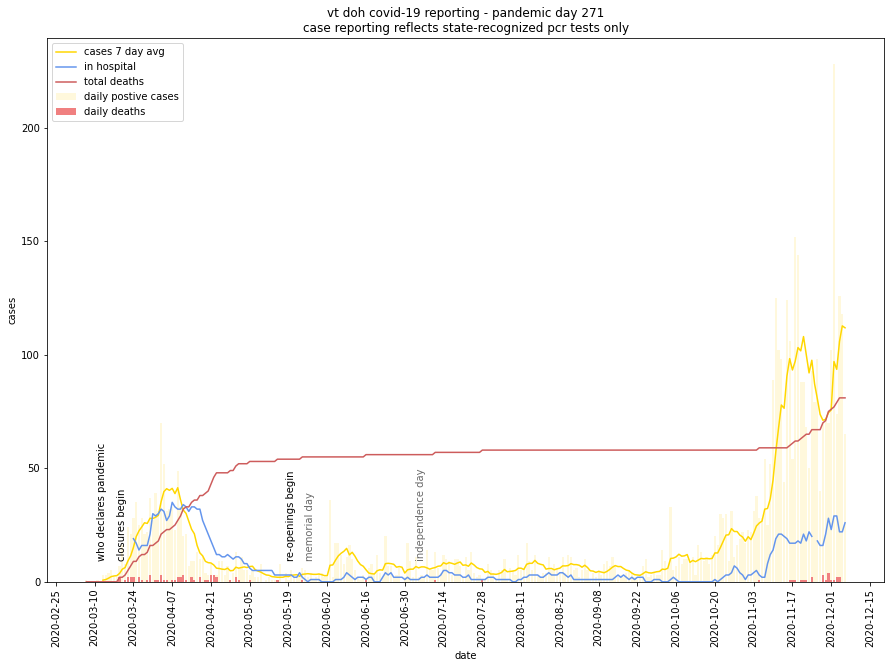

In [13]:
plt.figure(figsize=[15,10])
plt.grid(False)

# plot data
plt.plot(df_covid.date, pos_cases_avg, label='cases 7 day avg', color="gold")
plt.bar(df_covid.date, df_covid.positive_cases, label='daily postive cases', color="cornsilk")
plt.plot(df_covid.date, df_hospital.current_hospitalizations, label='in hospital', color="cornflowerblue")
plt.bar(df_covid.date, df_covid.daily_deaths, label='daily deaths', color='lightcoral')
plt.plot(df_covid.date, df_covid.total_deaths, label='total deaths', color='indianred')

# axis formatting
plt.xlabel("date")
plt.ylabel("cases")

# space date ticks two weeks apart
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.xticks(rotation=90)

# title and annotations
plt.title("vt doh covid-19 reporting - pandemic day " + str(pd_days) + "\ncase reporting reflects state-recognized pcr tests only")
plt.text(datetime.datetime(2020, 3, 11), 10, "who declares pandemic", rotation=90)
plt.text(datetime.datetime(2020, 3, 18), 10, "closures begin", rotation=90)
plt.text(datetime.datetime(2020, 5, 18), 10, "re-openings begin", rotation=90)
plt.text(datetime.datetime(2020, 5, 25), 10, "memorial day", rotation=90, color='dimgrey')
plt.text(datetime.datetime(2020, 7, 4), 10, "independence day", rotation=90, color='dimgrey')
plt.legend(loc=2)

The first graph is pretty straightforward using common features you'll find in most tutorials.

The tricky part was setting the dates on the X axis. Matplotlib mostly does the right thing by default, but sometimes the data flopped matplotlib into unexpected divisions. The following line uses `DayLocator()` to a 14-day increment.

`plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))`

It's worth walking through this since the documentation is a bit sparse. Basically I get the current X axis (`gca().xaxis`), and set the major locator (`.set_major_locator()`) using the interval option of `DayLocator()`.

## DataFrame Slices

The next chart makes use of the ability to grab just the last X records by using the `.tail()` method. I wanted to see a more recent slice of the data not dominated by the initial large avalance of cases.

Because of the shorter time span, I'm also using the `DayLocator(bymonthday=[1,8,15,22])` method to create weekly ticks.

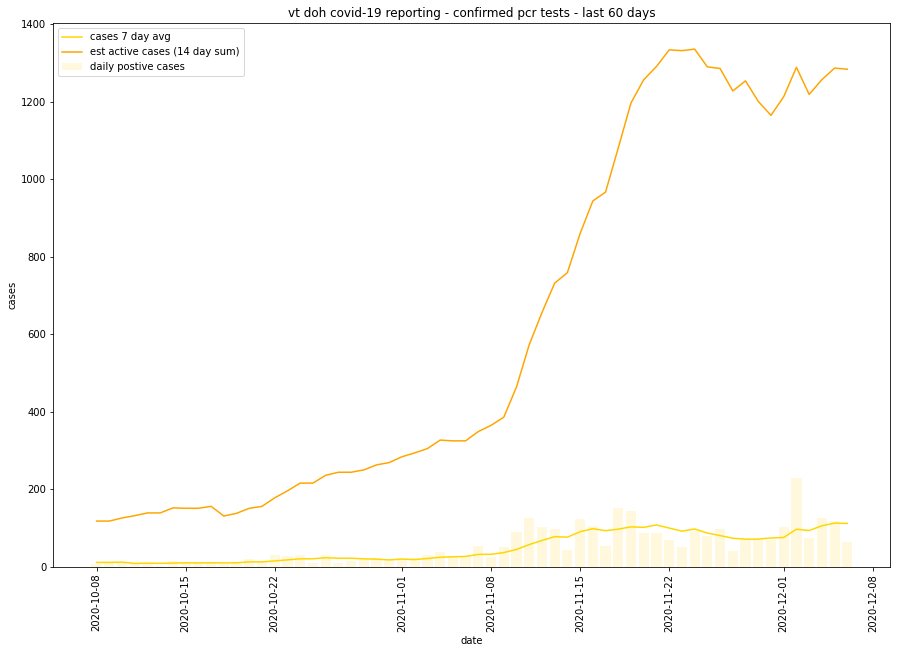

In [14]:
day_slice = 60

plt.figure(figsize=[15,10])
plt.grid(False)

plt.plot(df_covid.date.tail(day_slice), pos_cases_avg.tail(day_slice), label='cases 7 day avg', color="gold")
plt.bar(df_covid.date.tail(day_slice), df_covid.positive_cases.tail(day_slice), label='daily postive cases', color="cornsilk")
plt.plot(df_covid.date.tail(day_slice), active_cases_est.tail(day_slice), label='est active cases (14 day sum)', color="orange")

plt.xlabel("date")
plt.ylabel("cases")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(bymonthday=[1,8,15,22]))
plt.xticks(rotation=90)

#plt.text(datetime.datetime(2020, 5, 25), 10, "memorial day", rotation=90, color='dimgrey')
#plt.text(datetime.datetime(2020, 7, 4), 10, "independence day", rotation=90, color='dimgrey')
plt.title("vt doh covid-19 reporting - confirmed pcr tests - last " + str(day_slice) + " days")
plt.legend(loc=2)

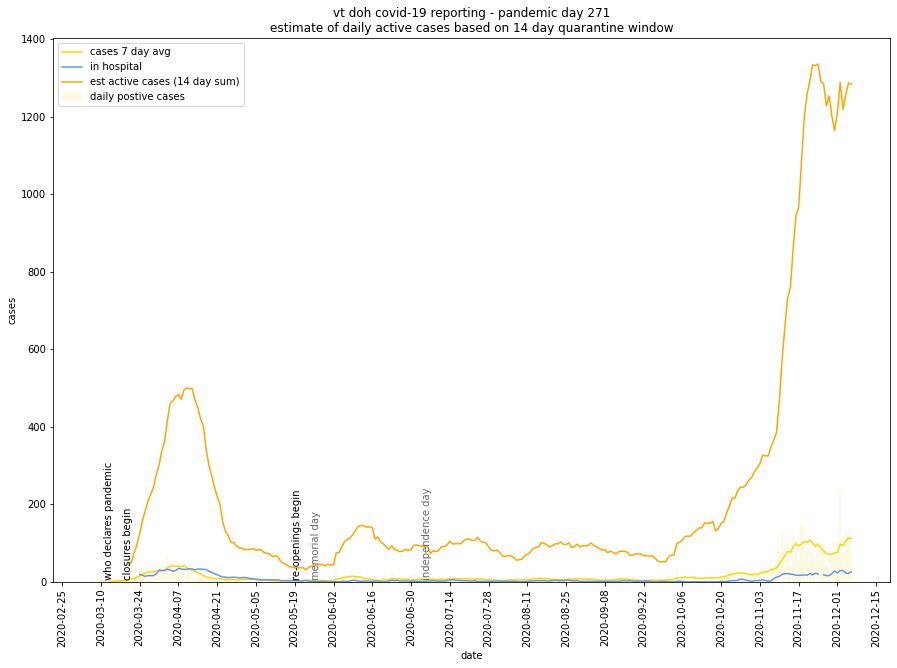

In [15]:
plt.figure(figsize=[15,10])
plt.grid(False)

plt.plot(df_covid.date, pos_cases_avg, label='cases 7 day avg', color="gold")
plt.bar(df_covid.date, df_covid.positive_cases, label='daily postive cases', color="cornsilk")
plt.plot(df_covid.date, df_hospital.current_hospitalizations, label='in hospital', color="cornflowerblue")
plt.plot(df_covid.date, active_cases_est, label='est active cases (14 day sum)', color="orange")

plt.xlabel("date")
plt.ylabel("cases")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.xticks(rotation=90)

plt.title("vt doh covid-19 reporting - pandemic day " + str(pd_days) + "\nestimate of daily active cases based on 14 day quarantine window")
plt.text(datetime.datetime(2020, 3, 11), 10, "who declares pandemic", rotation=90)
plt.text(datetime.datetime(2020, 3, 18), 10, "closures begin", rotation=90)
plt.text(datetime.datetime(2020, 5, 18), 10, "re-openings begin", rotation=90)
plt.text(datetime.datetime(2020, 5, 25), 10, "memorial day", rotation=90, color='dimgrey')
plt.text(datetime.datetime(2020, 7, 4), 10, "independence day", rotation=90, color='dimgrey')
plt.legend(loc=2)

This last chart would probably come out for publication.

## Conclusion

TBD